![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 06 - Convolutional Neural Network</center>
### <center> 2D convolution and Introduction to Pytorch</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/06_CNN/Main2D_Cnn.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
#-- Imports:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

#-- torch:
import torch

### Download CIFAR10 dataset:

In [4]:
import torchvision
import torchvision.transforms as transforms

oTrainSet = torchvision.datasets.CIFAR10(root='../data', train=True,  download=True, transform=transforms.ToTensor())
oTestSet  = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transforms.ToTensor())
oTrainSet.data.shape

Files already downloaded and verified
Files already downloaded and verified


(50000, 32, 32, 3)

### Compute mean and variance:

In [5]:
vMean = oTrainSet.data.mean(axis=(0,1,2)) / 255
vStd  = oTrainSet.data.std(axis=(0,1,2)) / 255
print('µ =', vMean)
print('σ =', vStd)

µ = [0.49139968 0.48215841 0.44653091]
σ = [0.24703223 0.24348513 0.26158784]


### Set datasets with normalization:

In [6]:
oTransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(vMean, vStd)
])

oTrainSet = torchvision.datasets.CIFAR10(root='../data', train=True,  transform=oTransform)
oTestSet  = torchvision.datasets.CIFAR10(root='../data', train=False, transform=oTransform)

lClasses  = oTrainSet.classes

### Plot some examples:

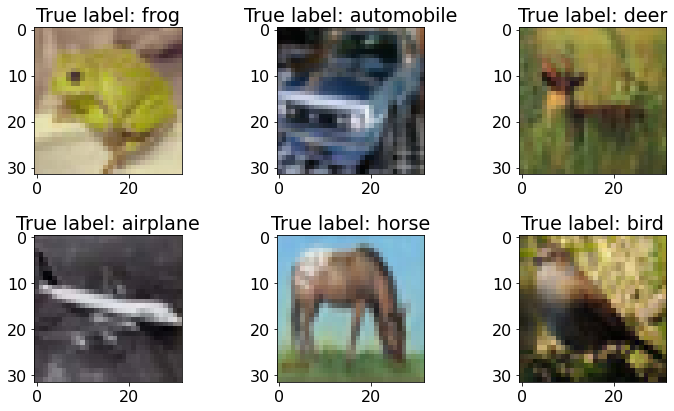

In [7]:
N, H, W, C = oTrainSet.data.shape
fig, _     = plt.subplots(2, 3, figsize=(10,6))
for ax in fig.axes:
    idx   = np.random.randint(0, N)
    mX, y = oTrainSet[idx]
    mX    = mX * vStd[:,None,None] + vMean[:,None,None] #-- unnormalizing, broadcast
    mX    = torch.clamp(mX, 0, 1)
    ax.imshow(np.transpose(mX.numpy(), [1, 2, 0]))
    ax.set_title('True label: ' + str(lClasses[y]))
    
plt.tight_layout()
plt.show()

### Create data loaders:

In [8]:
batchSize = 256
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize)

### Define the model (2D CNN):

In [9]:
import torch.nn            as nn
import torch.nn.functional as F
import torchsummary

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
#-- Tensor to vector (reshape):
class Flatten(nn.Module):
    def forward(self, input):
        out = input.view(input.size(0),-1)
        return out

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
#-- Just for the summary (identity):
class InputLayer(nn.Module):
    def forward(self, input):
        return input
    
#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
#-- Model:
def GetModel():
    oModel = nn.Sequential(
        InputLayer(), #-- does nothing
        
        nn.Conv2d     (in_channels=3,   out_channels=30,  kernel_size=3, bias=False),
        nn.BatchNorm2d(num_features=30),
        nn.ReLU       (),
        nn.Dropout2d  (p=0.2),
        
        nn.Conv2d     (in_channels=30,  out_channels=60,  kernel_size=3, bias=False),
        nn.MaxPool2d  (kernel_size=2),
        nn.BatchNorm2d(num_features=60),
        nn.ReLU       (),
        nn.Dropout2d  (p=0.2),
                
        nn.Conv2d     (in_channels=60,  out_channels=120, kernel_size=3, bias=False),
        nn.BatchNorm2d(120),
        nn.ReLU(),
        nn.Dropout2d(p=0.2),
        
        nn.Conv2d     (in_channels=120, out_channels=240, kernel_size=3, bias=False),
        nn.BatchNorm2d(240),
        nn.ReLU       (),
        nn.Dropout2d  (p=0.2),
        
        nn.Conv2d     (in_channels=240, out_channels=500, kernel_size=3, bias=False),
        nn.MaxPool2d  (2),
        nn.BatchNorm2d(500),
        nn.ReLU       (),
        
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(500, 10),
    )
    
    return oModel

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
torchsummary.summary(GetModel(), (C, H, W), device='cpu')
print()

------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─InputLayer: 1-1                        [-1, 3, 32, 32]           --
├─Conv2d: 1-2                            [-1, 30, 30, 30]          810
├─BatchNorm2d: 1-3                       [-1, 30, 30, 30]          60
├─ReLU: 1-4                              [-1, 30, 30, 30]          --
├─Dropout2d: 1-5                         [-1, 30, 30, 30]          --
├─Conv2d: 1-6                            [-1, 60, 28, 28]          16,200
├─MaxPool2d: 1-7                         [-1, 60, 14, 14]          --
├─BatchNorm2d: 1-8                       [-1, 60, 14, 14]          120
├─ReLU: 1-9                              [-1, 60, 14, 14]          --
├─Dropout2d: 1-10                        [-1, 60, 14, 14]          --
├─Conv2d: 1-11                           [-1, 120, 12, 12]         64,800
├─BatchNorm2d: 1-12                      [-1, 120, 12,

### Record figures during training:

In [10]:
class Plot:
    def __init__(self, sTitle, sLabel, sXlabel, sColor, vData=[]):
        self.sTitle  = sTitle
        self.sLabel  = sLabel
        self.sXlabel = sXlabel
        self.sColor  = sColor
        self.vData   = vData

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
class Recorder:
    def __init__(self, lPlots, figsize=(12,4)):
        self.lTitles = np.unique([oPlot.sTitle for oPlot in lPlots])
        self.N       = len(self.lTitles)
        self.fig, _  = plt.subplots(1, self.N, figsize=(12, 4))
        self.dAxes   = {}
        ii           = 0
        for oPlot in lPlots:
            ax = self.dAxes.get(oPlot.sTitle, None)
            if ax == None:
                ax                       = self.fig.axes[ii]
                ii                      += 1
                self.dAxes[oPlot.sTitle] = ax

            ax.set_title(oPlot.sTitle)
            ax.set_xlabel(oPlot.sXlabel)
            ax.plot(oPlot.vData, c=oPlot.sColor, label=oPlot.sLabel)
            ax.legend()
            ax.grid(True)

        plt.tight_layout()

    def Append(self, sTitle, sLabel, vData):
        ax = self.dAxes[sTitle]
        for oLine in ax.lines:
            if oLine.get_label() == sLabel:
                vYdata = np.append(oLine.get_ydata(), vData)
                N      = len(vYdata)
                oLine.set_data(list(range(N)), vYdata)
        lYlim = ax.axis()[2:4]
        ax.axis(xmin=0, xmax=N, ymin=np.minimum(np.min(vData), lYlim[0]), ymax=np.maximum(np.max(vData), lYlim[1]))

    def Draw(self):
        self.fig.canvas.draw()
        plt.pause(1e-10)

### Training loop:

In [11]:
def Accuracy(mHatY, vY):
    vHatY = mHatY.argmax(dim=1)
    return (vHatY == vY).float().mean().item()

In [12]:
import time

def TrainLoop(oModel, oTrainDL, LossFunc, oOptim):

    epochLoss = 0
    epochAcc  = 0
    count     = 0                                #-- number of samples
    device    = next(oModel.parameters()).device #-- CPU\GPU
    oModel.train(True)
    
    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oTrainDL):
        #-- Move to device (CPU\GPU):
        mX = mX.to(device)
        vY = vY.to(device)
        
        #-- Set gradients to zeros:
        oOptim.zero_grad()
        
        #-- Forward:
        mHatY = oModel(mX)
        loss  = LossFunc(mHatY, vY)

        #-- Backward:
        loss.backward()

        #-- Parameters update:
        oOptim.step()

        print(f'Iteration: {ii:3d}: loss = {loss:.6f}\r', end='')
        #-- Accumulate loss:
        Nb         = mX.shape[0]
        epochLoss += Nb * loss.item()
        epochAcc  += Nb * Accuracy(mHatY, vY)
        count     += Nb

    epochLoss /= count
    epochAcc  /= count

    return epochLoss, epochAcc

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def ValidationLoop(oModel, oValDL, LossFunc):

    epochLoss = 0
    epochAcc  = 0
    count     = 0                                #-- number of samples
    device    = next(oModel.parameters()).device #-- CPU\GPU
    
    #-- Iterate over the mini-batches:
    oModel.train(False)
    with torch.no_grad():
        for ii, (mX, vY) in enumerate(oValDL):
            #-- Move to device (CPU\GPU):
            mX = mX.to(device)
            vY = vY.to(device)
            
            #-- Forward:
            mHatY = oModel(mX)
            loss  = LossFunc(mHatY, vY)

            Nb         = len(vY)
            epochLoss += Nb * loss.item()
            epochAcc  += Nb * Accuracy(mHatY, vY)
            count     += Nb

    epochLoss /= count
    epochAcc  /= count

    return epochLoss, epochAcc

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def TrainModel(oModel, oTrainDL, oValDL, LossFunc, numEpochs, oOptim):

    oRecorder = Recorder([
        Plot('Loss',     'train', 'epoch', 'b'),
        Plot('Loss',     'val',   'epoch', 'r'),
        Plot('Accuracy', 'train', 'epoch', 'b'),
        Plot('Accuracy', 'val',   'epoch', 'r'),
    ])

    bestAcc = 0
    for epoch in range(numEpochs):
        startTime           = time.time()
        trainLoss, trainAcc = TrainLoop(oModel, oTrainDL, LossFunc, oOptim) #-- train
        valLoss,   valAcc   = ValidationLoop(oModel, oValDL, LossFunc)      #-- validation

        #-- Display:
        oRecorder.Append('Loss',     'train', trainLoss),
        oRecorder.Append('Loss',     'val',   valLoss),
        oRecorder.Append('Accuracy', 'train', trainAcc),
        oRecorder.Append('Accuracy', 'val',   valAcc),
        oRecorder.Draw()

        endTime = time.time()
        print('Epoch '              f'{epoch:3d}:',                  end='')
        print(' | Train loss: '     f'{trainLoss:.5f}',              end='')
        print(' | Val loss: '       f'{valLoss:.5f}',                end='')
        print(' | Train Accuracy: ' f'{trainAcc:2.4f}',              end='')
        print(' | Val Accuracy: '   f'{valAcc:2.4f}',                end='')
        print(' | epoch time: '     f'{(endTime-startTime):3.3f} |', end='')
        
        #-- Save best model:
        if valAcc > bestAcc:
            bestAcc   = valAcc
            try:
                torch.save(oModel.state_dict(), 'BestModelParameters.pt')
            except:
                pass
            print(' <-- Checkpoint!')
        else:
            print()

    oModel.load_state_dict(torch.load('BestModelParameters.pt'))

In [13]:
def LearningRateSweep(oModel, oTrainDL, LossFunc, oOptim, vLearningRate):
   
    #-- Record mini-batches loss:
    oRecorder = Recorder([Plot('Batch loss', 'train', 'learning rate', 'b')])

    numIter = len(vLearningRate)
    ii      = 0
    while ii < numIter:
        #-- Iterate over the mini-batches:
        for mX, vY in oTrainDL:
            if ii >= numIter:
                break

            #-- Move to device (CPU\GPU):
            mX = mX.to(device)
            vY = vY.to(device)
                        
            #-- Set gradients to zeros:
            oOptim.zero_grad()
                
            #-- Forward:
            mHatY = oModel(mX)
            loss  = LossFunc(mHatY, vY)

            #-- Backward:
            loss.backward()

            #-- Update parameters (with new learning rate)
            oOptim.param_groups[0]['lr'] = vLearningRate[ii]
            oOptim.step()

            oRecorder.Append('Batch loss', 'train', loss.item())
            oRecorder.Draw()        
        
            ii += 1
            
    #-- Display:
    ax = oRecorder.dAxes['Batch loss']
    ax.lines[0].set_xdata(vLearningRate)
    ax.axis(xmin=vLearningRate[0], xmax=vLearningRate[-1])
    ax.set_xscale('log')
    oRecorder.Draw()

### Check whether GPU is available:

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda', index=0)

###  Search learning rate:

<IPython.core.display.Javascript object>


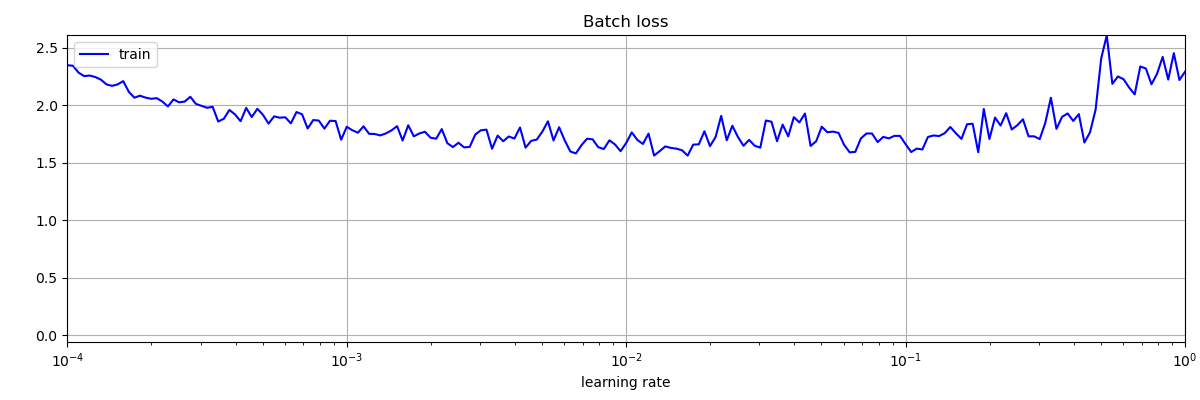

In [15]:
%matplotlib notebook

import torch.optim as optim

LossFunc      = nn.CrossEntropyLoss()
oModel        = GetModel().to(device)
oOptim        = optim.AdamW(oModel.parameters(), lr=1, betas=(0.9, 0.99), weight_decay=1e-2)
vLearningRate = np.logspace(-4, 0, 201)
LearningRateSweep(oModel, oTrainDL, LossFunc, oOptim, vLearningRate)

### Train the model:

<IPython.core.display.Javascript object>


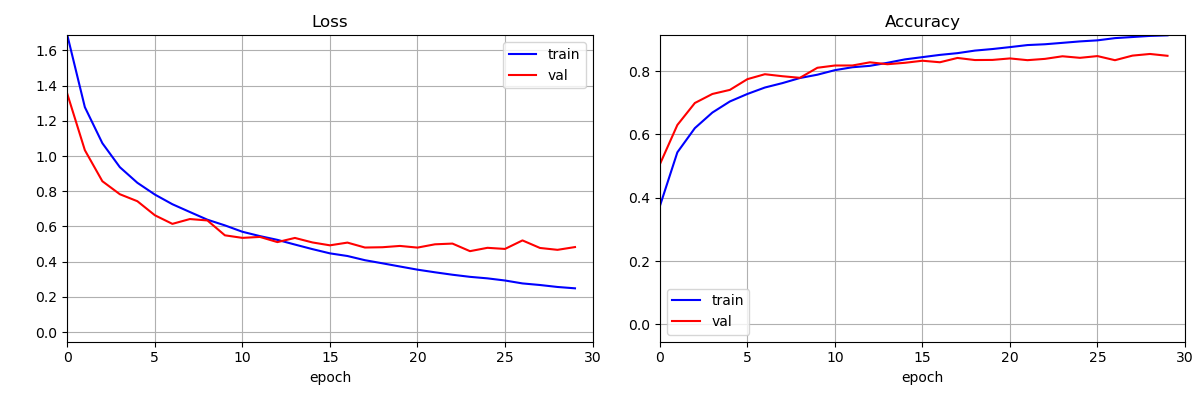

Epoch   0: | Train loss: 1.68573 | Val loss: 1.35218 | Train Accuracy: 0.3733 | Val Accuracy: 0.5054 | epoch time: 28.283 | <-- Checkpoint!
Epoch   1: | Train loss: 1.27777 | Val loss: 1.03339 | Train Accuracy: 0.5433 | Val Accuracy: 0.6297 | epoch time: 28.407 | <-- Checkpoint!
Epoch   2: | Train loss: 1.07299 | Val loss: 0.85686 | Train Accuracy: 0.6198 | Val Accuracy: 0.6992 | epoch time: 27.909 | <-- Checkpoint!
Epoch   3: | Train loss: 0.93658 | Val loss: 0.78294 | Train Accuracy: 0.6690 | Val Accuracy: 0.7277 | epoch time: 28.413 | <-- Checkpoint!
Epoch   4: | Train loss: 0.84798 | Val loss: 0.74330 | Train Accuracy: 0.7040 | Val Accuracy: 0.7406 | epoch time: 28.905 | <-- Checkpoint!
Epoch   5: | Train loss: 0.78111 | Val loss: 0.66342 | Train Accuracy: 0.7277 | Val Accuracy: 0.7745 | epoch time: 27.720 | <-- Checkpoint!
Epoch   6: | Train loss: 0.72619 | Val loss: 0.61460 | Train Accuracy: 0.7481 | Val Accuracy: 0.7901 | epoch time: 27.609 | <-- Checkpoint!
Epoch   7: | Train l

In [16]:
%matplotlib notebook

oModel   = GetModel().to(device)
oOptim   = optim.AdamW(oModel.parameters(), lr=4e-3, betas=(0.9, 0.99), weight_decay=1e-2)
TrainModel(oModel, oTrainDL, oTestDL, LossFunc, 30, oOptim)